In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
cwd = os.getcwd()
sep = os.sep

from adin.ml import baselineComparison, train_test_split, create_results_df

d:\anaconda3\envs\eabin13\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch 
from adin.utils import set_seed 

def set_deterministic(seed):
    global current_seed
    global is_deterministic

    #FOR REPRODUCIBILITY:
    print(f"SETTING DETERMINISTIC MODE FOR REPRODUCIBILITY, SEED: {seed}")
    os.environ["CUBLAS_WORKSPACE_CONFIG"]=":16:8"
    torch.use_deterministic_algorithms(True)
    set_seed(seed)
    current_seed = seed 
    is_deterministic = True

set_deterministic(0)

SETTING DETERMINISTIC MODE FOR REPRODUCIBILITY, SEED: 0


In [3]:
from adin import ml_config
ml_params = ml_config.ML_config("lbfgs", "l2", 100, "linear", 1.0, 5, "euclidean", 100, -1, -1, 2, 0.7, 5)
ml_params

In [4]:
pardir = cwd.split(sep)[:-1]
pardir_str = ""
for elem in pardir:
    pardir_str += elem + sep 
pardir = pardir_str
pardir

'c:\\Users\\Utente\\Desktop\\E-ABIN\\'

In [5]:
datasets_path = pardir + "use_case" + sep + "data" 
datasets_name = os.listdir(datasets_path)
datasets_name

['bladder_cancer', 'celiac', 'colorectal_cancer', 'parkinson']

In [8]:
def load_dataset(dataset_path):
    import pandas as pd 

    files = os.listdir(dataset_path)
    files = [file for file in files if ".csv" in file]
    if len(files) > 0:
        file = files[0]
        datapath = dataset_path + sep + file
        df = pd.read_csv(datapath, index_col = 0)
        return df
    else:
        return None

In [9]:
def compare_plot(df, column_name = "AUC score"):

    #vertical bar plot of the models' performance for different datasets
    # x dataset, group by model
    # y model performance metric (e.g., AUC score)
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    # Ensure the column exists in the DataFrame
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")
    # Convert the 'Model' column to string type if it's not already
    df['Model Name'] = df['Model Name'].astype(str)
    # Set the aesthetic style of the plots
    sns.set_theme(style="whitegrid")

    # Create a vertical bar plot
    fig = plt.figure(figsize=(12, 8))
    sns.barplot(x='Dataset', y=column_name, data=df, hue='Model Name', dodge=True)
    plt.title(f'Comparison of Models by {column_name}', fontsize=26, fontweight='bold')
    plt.xlabel('Dataset', fontsize=20, fontweight='bold')
    plt.ylabel(column_name, fontsize=20, fontweight='bold')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Model Name', bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize = 18, fontsize=14)
    plt.tight_layout()
    plt.show()
    return fig

In [10]:
import torch

def get_similarity(expr):

    # Move data to tensor, float32, and (optionally) to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    values = torch.as_tensor(expr, dtype=torch.float32, device=device)
    
    # Normalize the rows (L2 norm)
    values = torch.nn.functional.normalize(values, p=2, dim=1)
    
    # Compute cosine similarity matrix: sim[i, j] = cosine_similarity(values[i], values[j])
    sim_matrix = torch.matmul(values, values.T)

    return sim_matrix 


In [11]:
def get_edges(sim, th = 0.93):

    edges = torch.nonzero(sim > th, as_tuple=False)
    edges = edges[edges[:, 0] != edges[:, 1]]  # Remove self-loops
    edges = edges.cpu().numpy()
    edges_i = []
    for edge in edges:
        source, target = edge
        edges_i.append(f"{source}_{target}")
        
    return edges_i

In [ ]:
from adin import utils, gaan_config, dl
from adin.gaan import GAAN_Explainable
from torch_geometric.utils import add_self_loops
from adin import gcn
from adin.gae import GAE_Explainable
import numpy as np
from torch.cuda import empty_cache
from gc import collect

sims = {}
node_mappings = {}

def node_anomaly_detection(expr, targets, name, gaan_params = None, th = 0.93):

    global sims 

    expr = expr.values
    expr = torch.as_tensor(expr, dtype=torch.float32)
    x = expr.cpu().numpy()
    y = targets.values

    if name not in sims:
        print("Computing node similarity")
        sim = get_similarity(expr)
        sims[name] = sim.to("cpu")  # Store the similarity matrix in the global dictionary
    else:
        print("Using precomputed node similarity")
        sim = sims[name]

    del sim, expr 

    edges_i = get_edges(sims[name], th=0.93)
    source_nodes, target_nodes, node_mapping = utils.parse_edges(edges_i)
    edge_index = utils.create_edge_index(source_nodes, target_nodes)
    del source_nodes, target_nodes, edges_i
    
    mydataloader = dl.create_torch_geo_data(x, y, edge_index)
    del x, edge_index 

    dataloader_train, dataloader_test = dl.train_test_split_and_mask(mydataloader, train_size = 0.7)
    num_nodes = dataloader_train.x.shape[0] + dataloader_test.x.shape[0]
    dataloader_train.edge_index, _ = add_self_loops(dataloader_train.edge_index, num_nodes=num_nodes)
    dataloader_test.edge_index, _ = add_self_loops(dataloader_test.edge_index, num_nodes=num_nodes)
    in_dim = dataloader_train.x.shape[1]

    uqs, counts = np.unique(y, return_counts = True)
    dict_counts = {}
    for uq, count in zip(uqs, counts):
        dict_counts[uq.item()] = count.item()
    contamination = (dict_counts[1]/(dict_counts[0] + dict_counts[1]))*0.5

    gpu = 0 if torch.cuda.is_available() else -1
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    gaan_params = gaan_config.GAAN_config(noise_dim=64, hid_dim=128, num_layers=2, dropout=0.3, contamination=contamination, lr = 0.00005, epoch = 200, gpu = gpu, batch_size=1, verbose = 1, isn = False, th = 0.93)
            
    attrs = vars(gaan_params)
    print(', '.join("%s: %s" % item for item in attrs.items()))

    print("Create GAAN model")
    model_gaan = dl.create_model(in_dim, gaan_params, isn = False)
    model_gaan = dl.train_gaan(model_gaan, dataloader_train)
    collect()
    empty_cache()

    model_gae = GAE_Explainable(in_dim, device = device, hid_dim=gaan_params.hid_dim, num_layers=gaan_params.num_layers, dropout=gaan_params.dropout, contamination=gaan_params.contamination, lr=gaan_params.lr, epoch=gaan_params.epoch, verbose=gaan_params.verbose) #batch_size=gaan_params.batch_size
    model_gae.fit(dataloader_train)
    collect()
    empty_cache()
   
    lr = gaan_params.lr
    hidden_dims = [128]
    inchannels = mydataloader.x.shape[1]
    model_gcn = gcn.GCN(inchannels, hidden_dims=hidden_dims).to(device)
    criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
    optimizer = torch.optim.Adam(model_gcn.parameters(), lr=0.0005)  # Define optimizer.
    for epoch in range(2000):
        if epoch%100 == 0:
            print("Training GCN, epoch {}".format(epoch))
        loss = gcn.train(model_gcn, optimizer, criterion, dataloader_train)
    collect()
    empty_cache()
    models = {
        "GAAN": model_gaan,
        "GAE": model_gae,
        "GCN": model_gcn
    } 

    df_result = dl.create_results_df(models, dataloader_test)

    return df_result, models, dataloader_test

In [41]:
import pandas as pd


ths = {
    "celiac": 0.98,
    "bladder_cancer": 0.93,
    "colorectal_cancer": 0.98,
    "parkinson": 0.98,
}

df_result_dl = None

for i in range(2):
    print(f"Iteration {i+1} of 2")    
    for dataset_name in datasets_name:
        
        df = load_dataset(datasets_path + sep + dataset_name)
        if df is None:
            print(f"Dataset {dataset_name} not found or empty.")
            continue

        if "colorectal_cancer" != dataset_name:
            
            targets = df['Target']
            expr = df.drop(columns=['Target'])
            print("Running node anomaly detection, ", expr.shape)
            df_result, models_dl, dataloader_test = node_anomaly_detection(expr, targets, dataset_name, gaan_params=None, th = ths[dataset_name])
            df_result['Dataset'] = dataset_name
        
        df_result_dl = pd.concat([df_result_dl, df_result]) if df_result_dl is not None else df_result


Iteration 1 of 2
Running node anomaly detection,  (24, 27551)
Using precomputed node similarity
noise_dim: 64, hid_dim: 128, num_layers: 2, dropout: 0.3, act: <class 'torch.nn.modules.activation.ReLU'>, backbone: None, contamination: 0.375, lr: 5e-05, epoch: 200, gpu: 0, batch_size: 1, verbose: 1, isn: False, th: 0.93
Create GAAN model
Node Anomaly Detection task: expecting only one convergence/divergence graph
GPU: 0
Epoch 0000: Loss I 0.8575 | Loss O 2.1773 | 
Epoch 0001: Loss I 0.7731 | Loss O 2.1722 | 
Epoch 0002: Loss I 0.7932 | Loss O 2.3381 | 
Epoch 0003: Loss I 0.7744 | Loss O 1.9024 | 
Epoch 0004: Loss I 0.6597 | Loss O 4.7480 | 
Epoch 0005: Loss I 0.6789 | Loss O 2.0075 | 
Epoch 0006: Loss I 0.6714 | Loss O 1.7731 | 
Epoch 0007: Loss I 0.6345 | Loss O 1.8572 | 
Epoch 0008: Loss I 0.5870 | Loss O 1.8713 | 
Epoch 0009: Loss I 0.5885 | Loss O 2.3111 | 
Epoch 0010: Loss I 0.5557 | Loss O 1.7493 | 
Epoch 0011: Loss I 0.5377 | Loss O 1.6278 | 
Epoch 0012: Loss I 0.5438 | Loss O 1.6

In [27]:
import pandas as pd

df_result_ml = None 
for i in range(2):
    print(f"Iteration {i+1} of 2")
    for dataset_name in datasets_name:
    
        
        dataset_path = datasets_path + sep + dataset_name
        print(f"Loading dataset from {dataset_path}")
        df = load_dataset(dataset_path)
        if df is None:
            continue
        
        X_train, X_test, y_train, y_test = train_test_split(df, dataset_path, test_size = 0.7, target_name = 'Target')
        print("Running ML models")
        models_tuple, fig_roc, fig_box = baselineComparison(X_train, y_train, params = ml_params, grid_search=True)
            
        models = {}
        for model_name, model in models_tuple:
            models[model_name] = model


        df_result = create_results_df(models, X_test, y_test)
        df_result['Dataset'] = dataset_name  

        df_result_ml = pd.concat([df_result_ml, df_result]) if df_result_ml is not None else df_result

Iteration 1 of 2
Loading dataset from c:\Users\Utente\Desktop\E-ABIN\use_case\data\bladder_cancer
Loading train/test split from disk...
Running ML models
Number of splits for cross-validation: 5
Unique classes in target: {0: 2, 1: 5}
Not enough data for 5 splits, reducing to 2 splits.
Cross-validation splits:  2
Performing grid search for hyperparameter tuning...
Grid search for LR...
Performing grid search for LR with parameters: {'scaler': [None, MinMaxScaler(), StandardScaler()], 'model__solver': ['liblinear', 'saga'], 'model__penalty': ['l2', 'l1', None], 'model__max_iter': [100, 200, 300]}


d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning:


18 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\pipeline.py", line 663, in fit
    self._final_estimat

Best parameters: {'model__max_iter': 100, 'model__penalty': 'l2', 'model__solver': 'liblinear', 'scaler': None}
Best score: 1.0000
Best model for LR: Pipeline(steps=[('scaler', None),
                ('model',
                 LogisticRegression(class_weight='balanced',
                                    solver='liblinear'))])
Grid search for KNN...
Performing grid search for KNN with parameters: {'scaler': [None, MinMaxScaler(), StandardScaler()], 'model__n_neighbors': [3, 5, 7], 'model__metric': ['euclidean', 'manhattan']}


d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [0.5   0.5   0.5     nan   nan   nan   nan   nan   nan 0.5   0.625 0.625
 0.5   0.5   0.5   0.5   0.5   0.5  ]



Best parameters: {'model__metric': 'manhattan', 'model__n_neighbors': 3, 'scaler': MinMaxScaler()}
Best score: 0.6250
Best model for KNN: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=3))])
Grid search for DT...
Performing grid search for DT with parameters: {'scaler': [None], 'model__max_depth': [None, 5, 10], 'model__min_samples_split': [2, 5, 10]}
Best parameters: {'model__max_depth': 10, 'model__min_samples_split': 2, 'scaler': None}
Best score: 0.8333
Best model for DT: Pipeline(steps=[('scaler', None),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced',
                                        max_depth=10))])
Grid search for SVM...
Performing grid search for SVM with parameters: {'scaler': [None, MinMaxScaler(), StandardScaler()], 'model__kernel': ['linear', 'rbf'], 'model__C': [0.1, 1, 10]}
Best parameters: {'model__C': 0.1, 'model__kernel': 'linea

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Loading dataset from c:\Users\Utente\Desktop\E-ABIN\use_case\data\celiac
Loading train/test split from disk...
Running ML models
Number of splits for cross-validation: 5
Unique classes in target: {0: 6, 1: 33}
Cross-validation splits:  5
Performing grid search for hyperparameter tuning...
Grid search for LR...
Performing grid search for LR with parameters: {'scaler': [None, MinMaxScaler(), StandardScaler()], 'model__solver': ['liblinear', 'saga'], 'model__penalty': ['l2', 'l1', None], 'model__max_iter': [100, 200, 300]}


d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning:


45 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\pipeline.py", line 663, in fit
    self._final_estimat

Best parameters: {'model__max_iter': 100, 'model__penalty': 'l1', 'model__solver': 'saga', 'scaler': MinMaxScaler()}
Best score: 0.8571
Best model for LR: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', penalty='l1',
                                    solver='saga'))])
Grid search for KNN...
Performing grid search for KNN with parameters: {'scaler': [None, MinMaxScaler(), StandardScaler()], 'model__n_neighbors': [3, 5, 7], 'model__metric': ['euclidean', 'manhattan']}
Best parameters: {'model__metric': 'euclidean', 'model__n_neighbors': 7, 'scaler': None}
Best score: 0.8131
Best model for KNN: Pipeline(steps=[('scaler', None),
                ('model',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=7))])
Grid search for DT...
Performing grid search for DT with parameters: {'scaler': [None], 'model__max_depth': [None, 5, 10], 'model__min_samples_split': [2, 5, 10]}
Best parameters: 

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



LR: 0.8833 (0.1633)
KNN: 0.7833 (0.2963)
DT: 0.6095 (0.1661)
SVM: 0.1167 (0.1633)
RF: 0.9083 (0.1190)
LR [0.5833333333333334, 1.0, 1.0, 1.0, 0.8333333333333334]
KNN [0.6666666666666667, 1.0, 1.0, 1.0, 0.25]
DT [0.5, 0.7857142857142857, 0.5, 0.42857142857142855, 0.8333333333333333]
SVM [0.4166666666666667, 0.0, 0.0, 0.0, 0.16666666666666666]
RF [0.7083333333333333, 1.0, 1.0, 1.0, 0.8333333333333334]
Best model: RF with roc_auc: 0.9083


d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

d:\anaco

Loading dataset from c:\Users\Utente\Desktop\E-ABIN\use_case\data\colorectal_cancer
Loading train/test split from disk...
Running ML models
Number of splits for cross-validation: 5
Unique classes in target: {0: 7, 1: 37}
Cross-validation splits:  5
Performing grid search for hyperparameter tuning...
Grid search for LR...
Performing grid search for LR with parameters: {'scaler': [None, MinMaxScaler(), StandardScaler()], 'model__solver': ['liblinear', 'saga'], 'model__penalty': ['l2', 'l1', None], 'model__max_iter': [100, 200, 300]}


d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning:


45 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\pipeline.py", line 663, in fit
    self._final_estimat

Best parameters: {'model__max_iter': 100, 'model__penalty': 'l2', 'model__solver': 'liblinear', 'scaler': MinMaxScaler()}
Best score: 1.0000
Best model for LR: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced',
                                    solver='liblinear'))])
Grid search for KNN...
Performing grid search for KNN with parameters: {'scaler': [None, MinMaxScaler(), StandardScaler()], 'model__n_neighbors': [3, 5, 7], 'model__metric': ['euclidean', 'manhattan']}
Best parameters: {'model__metric': 'euclidean', 'model__n_neighbors': 3, 'scaler': None}
Best score: 1.0000
Best model for KNN: Pipeline(steps=[('scaler', None),
                ('model',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=3))])
Grid search for DT...
Performing grid search for DT with parameters: {'scaler': [None], 'model__max_depth': [None, 5, 10], 'model__min_samples_split': [2, 5, 10]}
Best parameters: {'mo

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning:


45 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\pipeline.py", line 663, in fit
    self._final_estimat

Best parameters: {'model__max_iter': 200, 'model__penalty': 'l1', 'model__solver': 'saga', 'scaler': MinMaxScaler()}
Best score: 0.6167
Best model for LR: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=200,
                                    penalty='l1', solver='saga'))])
Grid search for KNN...
Performing grid search for KNN with parameters: {'scaler': [None, MinMaxScaler(), StandardScaler()], 'model__n_neighbors': [3, 5, 7], 'model__metric': ['euclidean', 'manhattan']}
Best parameters: {'model__metric': 'euclidean', 'model__n_neighbors': 3, 'scaler': MinMaxScaler()}
Best score: 0.7222
Best model for KNN: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=3))])
Grid search for DT...
Performing grid search for DT with parameters: {'scaler': [None], 'model__max_depth': [None, 5, 10], 'model__min_samples_spl

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



LR: 0.4000 (0.1133)
KNN: 0.5917 (0.2794)
DT: 0.3833 (0.0667)
SVM: 0.5778 (0.1879)
RF: 0.3056 (0.2018)
LR [0.3333333333333333, 0.22222222222222224, 0.5555555555555556, 0.4444444444444444, 0.4444444444444445]
KNN [0.29166666666666663, 0.5, 0.33333333333333337, 1.0, 0.8333333333333333]
DT [0.41666666666666663, 0.5, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337]
SVM [0.5, 0.33333333333333337, 0.888888888888889, 0.6666666666666666, 0.5]
RF [0.25, 0.0, 0.22222222222222224, 0.5555555555555556, 0.5]
Best model: KNN with roc_auc: 0.5917
Iteration 2 of 2
Loading dataset from c:\Users\Utente\Desktop\E-ABIN\use_case\data\bladder_cancer
Loading train/test split from disk...
Running ML models
Number of splits for cross-validation: 5
Unique classes in target: {0: 2, 1: 5}
Not enough data for 5 splits, reducing to 2 splits.
Cross-validation splits:  2
Performing grid search for hyperparameter tuning...
Grid search for LR...
Performing grid search for LR with parameters: {'scaler': [Non

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning:


18 fits failed out of a total of 108.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\pipeline.py", line 663, in fit
    self._final_estimat

Best parameters: {'model__max_iter': 100, 'model__penalty': 'l2', 'model__solver': 'liblinear', 'scaler': None}
Best score: 1.0000
Best model for LR: Pipeline(steps=[('scaler', None),
                ('model',
                 LogisticRegression(class_weight='balanced',
                                    solver='liblinear'))])
Grid search for KNN...
Performing grid search for KNN with parameters: {'scaler': [None, MinMaxScaler(), StandardScaler()], 'model__n_neighbors': [3, 5, 7], 'model__metric': ['euclidean', 'manhattan']}


d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning:

One or more of the test scores are non-finite: [0.5   0.5   0.5     nan   nan   nan   nan   nan   nan 0.5   0.625 0.625
 0.5   0.5   0.5   0.5   0.5   0.5  ]



Best parameters: {'model__metric': 'manhattan', 'model__n_neighbors': 3, 'scaler': MinMaxScaler()}
Best score: 0.6250
Best model for KNN: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 KNeighborsClassifier(metric='manhattan', n_neighbors=3))])
Grid search for DT...
Performing grid search for DT with parameters: {'scaler': [None], 'model__max_depth': [None, 5, 10], 'model__min_samples_split': [2, 5, 10]}
Best parameters: {'model__max_depth': 5, 'model__min_samples_split': 2, 'scaler': None}
Best score: 0.5833
Best model for DT: Pipeline(steps=[('scaler', None),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=5))])
Grid search for SVM...
Performing grid search for SVM with parameters: {'scaler': [None, MinMaxScaler(), StandardScaler()], 'model__kernel': ['linear', 'rbf'], 'model__C': [0.1, 1, 10]}
Best parameters: {'model__C': 0.1, 'model__kernel': 'linear', 'scaler': None}
Best score: 1.0000
Bes

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Loading dataset from c:\Users\Utente\Desktop\E-ABIN\use_case\data\celiac
Loading train/test split from disk...
Running ML models
Number of splits for cross-validation: 5
Unique classes in target: {0: 6, 1: 33}
Cross-validation splits:  5
Performing grid search for hyperparameter tuning...
Grid search for LR...
Performing grid search for LR with parameters: {'scaler': [None, MinMaxScaler(), StandardScaler()], 'model__solver': ['liblinear', 'saga'], 'model__penalty': ['l2', 'l1', None], 'model__max_iter': [100, 200, 300]}


d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning:


45 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\pipeline.py", line 663, in fit
    self._final_estimat

Best parameters: {'model__max_iter': 100, 'model__penalty': 'l1', 'model__solver': 'saga', 'scaler': MinMaxScaler()}
Best score: 0.8571
Best model for LR: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', penalty='l1',
                                    solver='saga'))])
Grid search for KNN...
Performing grid search for KNN with parameters: {'scaler': [None, MinMaxScaler(), StandardScaler()], 'model__n_neighbors': [3, 5, 7], 'model__metric': ['euclidean', 'manhattan']}
Best parameters: {'model__metric': 'euclidean', 'model__n_neighbors': 7, 'scaler': None}
Best score: 0.8131
Best model for KNN: Pipeline(steps=[('scaler', None),
                ('model',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=7))])
Grid search for DT...
Performing grid search for DT with parameters: {'scaler': [None], 'model__max_depth': [None, 5, 10], 'model__min_samples_split': [2, 5, 10]}
Best parameters: 

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



LR: 0.8310 (0.1630)
KNN: 0.7929 (0.2695)
DT: 0.4952 (0.1254)
SVM: 0.1405 (0.1770)
RF: 0.8429 (0.1829)
LR [0.5833333333333334, 0.7142857142857143, 0.8571428571428571, 1.0, 1.0]
KNN [0.75, 0.2857142857142857, 1.0, 0.9285714285714286, 1.0]
DT [0.5, 0.5, 0.42857142857142855, 0.7142857142857143, 0.3333333333333333]
SVM [0.4166666666666667, 0.2857142857142857, 0.0, 0.0, 0.0]
RF [0.5, 0.8571428571428571, 0.8571428571428571, 1.0, 1.0]
Best model: RF with roc_auc: 0.8429


d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

d:\anaco

Loading dataset from c:\Users\Utente\Desktop\E-ABIN\use_case\data\colorectal_cancer
Loading train/test split from disk...
Running ML models
Number of splits for cross-validation: 5
Unique classes in target: {0: 7, 1: 37}
Cross-validation splits:  5
Performing grid search for hyperparameter tuning...
Grid search for LR...
Performing grid search for LR with parameters: {'scaler': [None, MinMaxScaler(), StandardScaler()], 'model__solver': ['liblinear', 'saga'], 'model__penalty': ['l2', 'l1', None], 'model__max_iter': [100, 200, 300]}


d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning:


45 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\pipeline.py", line 663, in fit
    self._final_estimat

Best parameters: {'model__max_iter': 100, 'model__penalty': 'l2', 'model__solver': 'liblinear', 'scaler': MinMaxScaler()}
Best score: 1.0000
Best model for LR: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced',
                                    solver='liblinear'))])
Grid search for KNN...
Performing grid search for KNN with parameters: {'scaler': [None, MinMaxScaler(), StandardScaler()], 'model__n_neighbors': [3, 5, 7], 'model__metric': ['euclidean', 'manhattan']}
Best parameters: {'model__metric': 'euclidean', 'model__n_neighbors': 3, 'scaler': None}
Best score: 1.0000
Best model for KNN: Pipeline(steps=[('scaler', None),
                ('model',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=3))])
Grid search for DT...
Performing grid search for DT with parameters: {'scaler': [None], 'model__max_depth': [None, 5, 10], 'model__min_samples_split': [2, 5, 10]}
Best parameters: {'mo

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning:


45 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\pipeline.py", line 663, in fit
    self._final_estimat

Best parameters: {'model__max_iter': 200, 'model__penalty': 'l1', 'model__solver': 'saga', 'scaler': MinMaxScaler()}
Best score: 0.6167
Best model for LR: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=200,
                                    penalty='l1', solver='saga'))])
Grid search for KNN...
Performing grid search for KNN with parameters: {'scaler': [None, MinMaxScaler(), StandardScaler()], 'model__n_neighbors': [3, 5, 7], 'model__metric': ['euclidean', 'manhattan']}
Best parameters: {'model__metric': 'euclidean', 'model__n_neighbors': 3, 'scaler': MinMaxScaler()}
Best score: 0.7222
Best model for KNN: Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=3))])
Grid search for DT...
Performing grid search for DT with parameters: {'scaler': [None], 'model__max_depth': [None, 5, 10], 'model__min_samples_spl

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

d:\anaconda3\envs\eabin13\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



LR: 0.5833 (0.2992)
KNN: 0.4833 (0.1856)
DT: 0.5417 (0.1624)
SVM: 0.3944 (0.2183)
RF: 0.1444 (0.1556)
LR [0.9166666666666666, 0.4444444444444445, 0.11111111111111112, 0.888888888888889, 0.5555555555555556]
KNN [0.75, 0.33333333333333337, 0.33333333333333337, 0.33333333333333337, 0.6666666666666667]
DT [0.5416666666666666, 0.33333333333333337, 0.8333333333333333, 0.5, 0.5]
SVM [0.25, 0.5555555555555556, 0.3333333333333333, 0.11111111111111112, 0.7222222222222223]
RF [0.3333333333333333, 0.33333333333333337, 0.0, 0.0, 0.05555555555555556]
Best model: LR with roc_auc: 0.5833


In [42]:
df_result_all = pd.concat([df_result_ml, df_result_dl], ignore_index=True)
df_result_all

,Model Name,Accuracy,F1,Sensitivity,Specificity,AUC score,Precision,Dataset
0,LR,100.000,1.000000,100.000000,100.000000,1.000000,100.000000,bladder_cancer
1,RF,88.240,0.930000,100.000000,50.000000,1.000000,86.670000,bladder_cancer
2,DT,82.350,0.880000,84.620000,75.000000,0.800000,91.670000,bladder_cancer
3,KNN,76.470,0.870000,100.000000,0.000000,0.650000,76.470000,bladder_cancer
4,SVM,100.000,1.000000,100.000000,100.000000,0.000000,100.000000,bladder_cancer
...,...,...,...,...,...,...,...,...
59,GAE,35.000,0.480000,36.363636,28.571429,0.324675,70.588235,celiac
60,GCN,82.500,0.904110,100.000000,0.000000,0.500000,82.500000,celiac
61,GAAN,46.875,0.190476,13.333333,76.470588,0.449020,33.333333,parkinson
62,GAE,40.625,0.240000,20.000000,58.823529,0.394118,30.000000,parkinson


In [43]:
df_result_all.to_csv(cwd + sep + "eabin_internal_comparison.csv", index=False)
df_result_all

,Model Name,Accuracy,F1,Sensitivity,Specificity,AUC score,Precision,Dataset
0,LR,100.000,1.000000,100.000000,100.000000,1.000000,100.000000,bladder_cancer
1,RF,88.240,0.930000,100.000000,50.000000,1.000000,86.670000,bladder_cancer
2,DT,82.350,0.880000,84.620000,75.000000,0.800000,91.670000,bladder_cancer
3,KNN,76.470,0.870000,100.000000,0.000000,0.650000,76.470000,bladder_cancer
4,SVM,100.000,1.000000,100.000000,100.000000,0.000000,100.000000,bladder_cancer
...,...,...,...,...,...,...,...,...
59,GAE,35.000,0.480000,36.363636,28.571429,0.324675,70.588235,celiac
60,GCN,82.500,0.904110,100.000000,0.000000,0.500000,82.500000,celiac
61,GAAN,46.875,0.190476,13.333333,76.470588,0.449020,33.333333,parkinson
62,GAE,40.625,0.240000,20.000000,58.823529,0.394118,30.000000,parkinson


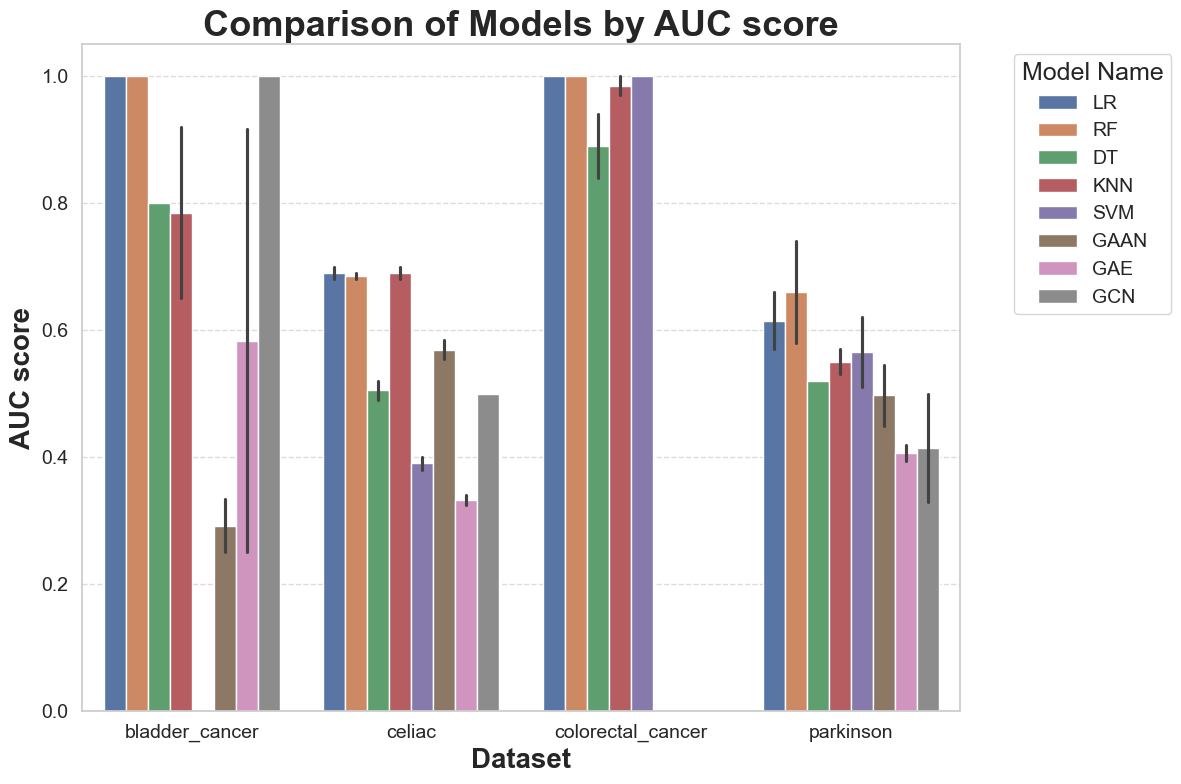

In [46]:
fig_compare = compare_plot(df_result_all, column_name = "AUC score")

In [45]:
fig_compare.savefig(cwd + sep + "eabin_internal_comparison_auc.png", dpi=600, bbox_inches='tight')